In [1]:
import os
import sys
import numpy as np
import pandas as pd
import csv
import open3d as o3d
from matplotlib import pyplot as plt
import scipy
import scipy.io
import skimage
import ssm_utils
from recons_eval_metric import computeRMSE, computeRMSD, computeASSD, computeHD, computeChamferDistance
import projection_utils as proj
import functools
import ray
import psutil
from projection_utils import PHOTO
from emopt5views_cpd import EMOpt5Views
import emopt_func

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# SSM_DIR = r"./data/cpdAlignedData/eigValVec/" 
# CPD_ALIGNED_DIR = r"./data/cpdAlignedData/" 
# PARAM_DIR = r"./data/params/" 
# SRC_DIR = r"./dataWithPhoto/cpdAlignedData/"
# SRC_PARAM_DIR = r"./dataWithPhoto/params/" 

SSM_DIR = r"./data/cpdGpAlignedData/eigValVec/" 
CPD_ALIGNED_DIR = r"./data/cpdGpAlignedData/" 
PARAM_DIR = r"./data/cpdGpParams/" 
SRC_DIR = r"./dataWithPhoto/cpdGpAlignedData/"
SRC_PARAM_DIR = r"./dataWithPhoto/cpdGpParams/"

NUM_PC = 10 # 3
NUM_POINT = 1500
PG_SHAPE = (NUM_POINT, 3)
UPPER_INDICES = [11,12,13,14,15,16,17,21,22,23,24,25,26,27] #不考虑智齿18,28
LOWER_INDICES = [31,32,33,34,35,36,37,41,42,43,44,45,46,47] #不考虑智齿38,48
NAME_IDX_MAP_CSV = r"./dataWithPhoto/nameIndexMapping.csv"
PG_NPY = os.path.join(SRC_PARAM_DIR, "Y_pg.npy")
MASK_NPY = os.path.join(SRC_PARAM_DIR, "X_mask.npy")
VERSION = "v21" # version of teeth silouette extraction model

DEMO_H5_DIR = r"./dataWithPhoto/demo/"
DEMO_MESH_DIR = r"./dataWithPhoto/demoMesh/"
TEMP_DIR = r"./dataWithPhoto/"
LOG_DIR = r"./dataWithPhoto/log/"
STAGE0_MAT_DIR = r"./dataWithPhoto//stage0mat/"
for d in [TEMP_DIR, STAGE0_MAT_DIR, DEMO_H5_DIR, DEMO_MESH_DIR, LOG_DIR]:
    os.makedirs(d, exist_ok=True)
    
# print = functools.partial(print, flush=True)



Fold1_TagIDs = [66,62,44,2,38,78,4,67,11,85,50,51,79,57,33,77,94,23,21]
Fold2_TagIDs = [64,89,6,58,31,86,3,27,35,45,26,36,8,76,55,17,22,82,48]
Fold3_TagIDs = [9,87,88,80,61,30,41,34,74,25,13,0,16,20,15,19,93,59,49]
Fold4_TagIDs = [73,32,69,5,40,72,43,75,1,28,7,92,91,37,68,60,81,14,52]
Fold5_TagIDs = [63,47,24,54,10,42,18,90,70,46,71,83,84,56,65,53,39,29,12]

TagIDs = Fold5_TagIDs + Fold4_TagIDs + Fold3_TagIDs + Fold2_TagIDs + Fold1_TagIDs

TagID_Folds = {1:Fold1_TagIDs, 2:Fold2_TagIDs, 3:Fold3_TagIDs, 4:Fold4_TagIDs, 5:Fold5_TagIDs}



# # Run it only once
# ssm_utils.saveEigValVec(CPD_ALIGNED_DIR, NumPC2Save=100)

# # Run it only once
# src_invRegistrationParamDF = proj.loadInvRegistrationParams(loadDir=SRC_PARAM_DIR) # 加载待优化点云配准过程中的参数
# Mu, SqrtEigVals, Sigma = proj.loadMuEigValSigma(SSM_DIR, numPC=NUM_PC)
# Y_pg, X_mask, Y_scale, Y_rxyz, Y_txyz, Y_fVec = proj.loadDataSet(src_invRegistrationParamDF, Mu, Sigma, pgShape=PG_SHAPE, srcRootDir=SRC_DIR)
# np.save(PG_NPY, np.array(Y_pg))
# np.save(MASK_NPY, np.array(X_mask))

In [3]:
FOLD_IDX = 5
TagID = 63

In [4]:
# 顺序相互对应
str_photo_types = ["upperPhoto","lowerPhoto","leftPhoto","rightPhoto","frontalPhoto"]

# 初始化
photoTypes = [PHOTO.UPPER, PHOTO.LOWER, PHOTO.LEFT, PHOTO.RIGHT, PHOTO.FRONTAL]
VISIBLE_MASKS = [proj.MASK_UPPER, proj.MASK_LOWER, proj.MASK_LEFT, proj.MASK_RIGHT, proj.MASK_FRONTAL]
Mu, SqrtEigVals, Sigma = proj.loadMuEigValSigma(SSM_DIR, numPC=NUM_PC)
Mu_normals = emopt_func.computeGroupedPointNormals(Mu)

invRegistrationParamDF = proj.loadInvRegistrationParams(loadDir=PARAM_DIR) # 加载配准过程中的参数
invParamDF = proj.updateAbsTransVecs(invRegistrationParamDF, Mu) # 将牙列scale转化为每颗牙齿的位移，将每颗牙齿的transVecXYZs在局部坐标系下进行表达

invScaleMeans, invScaleVars, invRotVecXYZMeans, invRotVecXYZVars, invTransVecXYZMeans, invTransVecXYZVars = proj.getMeanAndVarianceOfInvRegistrationParams(invParamDF)
scaleStds = np.sqrt(invScaleVars)
transVecStds = np.sqrt(invTransVecXYZVars)
rotVecStds = np.sqrt(invRotVecXYZVars)
print("scaleStd: {:.4f}, transVecStd: {:.4f}, rotVecStd: {:.4f}".format(scaleStds.mean(), transVecStds.mean(), rotVecStds.mean()))

PoseCovMats = proj.GetPoseCovMats(invParamDF, toothIndices=UPPER_INDICES+LOWER_INDICES) # 每个位置的牙齿的6个变换参数的协方差矩阵,shape=(28,6,6)
ScaleCovMat = proj.GetScaleCovMat(invParamDF, toothIndices=UPPER_INDICES+LOWER_INDICES) # 牙齿scale的协方差矩阵,shape=(28,28)
name_idx_df = pd.read_csv(NAME_IDX_MAP_CSV)

EDGE_MASK_PATH = r"./dataWithPhoto/learning/fold{}/test/pred-{}/".format(FOLD_IDX, VERSION)

edgeMasks = proj.getEdgeMask(EDGE_MASK_PATH, name_idx_df, TagID, str_photo_types, resized_width=800, binary=True, activation_thre=0.1)
Mask = proj.GetMaskByTagId(MASK_NPY, TagId=TagID)
PG_Ref = proj.GetPGByTagId(PG_NPY, TagId=TagID)
X_Ref = PG_Ref[Mask]

scaleStd: 0.0665, transVecStd: 1.1844, rotVecStd: 0.1391
['./dataWithPhoto/learning/fold5/test/pred-v21/安然_219474_上牙列.png', './dataWithPhoto/learning/fold5/test/pred-v21/安然_219474_下牙列.png', './dataWithPhoto/learning/fold5/test/pred-v21/安然_219474_左侧咬合.png', './dataWithPhoto/learning/fold5/test/pred-v21/安然_219474_右侧咬合.png', './dataWithPhoto/learning/fold5/test/pred-v21/安然_219474_正位像.png']


In [21]:
emopt = EMOpt5Views(edgeMasks, photoTypes, VISIBLE_MASKS, Mask, Mu, Mu_normals,\
    SqrtEigVals, Sigma, PoseCovMats, ScaleCovMat, transVecStds.mean(), rotVecStds.mean())

In [22]:
print("num of observed edge points: ", emopt.M)
print("ex_rxyz: ", emopt.ex_rxyz)
print("ex_txyz: ", emopt.ex_txyz)
print("rela_rxyz: ", emopt.rela_rxyz)
print("rela_txyz: ", emopt.rela_txyz)
print("focal length: ", emopt.focLth)
print("d_pixel: ", emopt.dpix)
print("u0: {}, v0: {}".format(emopt.u0, emopt.v0))
print("[RMSE] Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(emopt.X_trans, X_Ref)))
print("[ASSD] average symmetric surface distance (mm): {:.4f}".format(computeASSD(emopt.X_trans, X_Ref)))
print("[HD] Hausdorff distance (mm): {:.4f}".format(computeHD(emopt.X_trans, X_Ref)))

num of observed edge points:  [3000, 3000, 3000, 3000, 3000]
ex_rxyz:  [[ 2.19911486  0.          0.        ]
 [-2.19911486  0.          0.        ]
 [ 2.8         0.         -1.42      ]
 [ 2.8         0.          1.42      ]
 [ 3.14159265  0.          0.        ]]
ex_txyz:  [[  0.   0.  70.]
 [  0.   0.  70.]
 [ -5.   0. 120.]
 [  5.   0. 120.]
 [  0.  -2. 120.]]
rela_rxyz:  [0. 0. 0.]
rela_txyz:  [ 0. -5.  0.]
focal length:  [100. 100. 100. 100. 100.]
d_pixel:  [0.1  0.1  0.06 0.06 0.06]
u0: [400. 400. 400. 400. 400.], v0: [300. 300. 300. 300. 300.]
[RMSE] Root Mean Squared Surface Distance(mm): 2.3826
[ASSD] average symmetric surface distance (mm): 1.0850
[HD] Hausdorff distance (mm): 2.7051


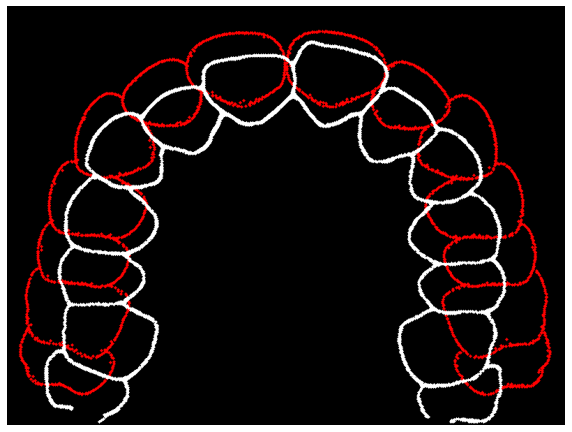

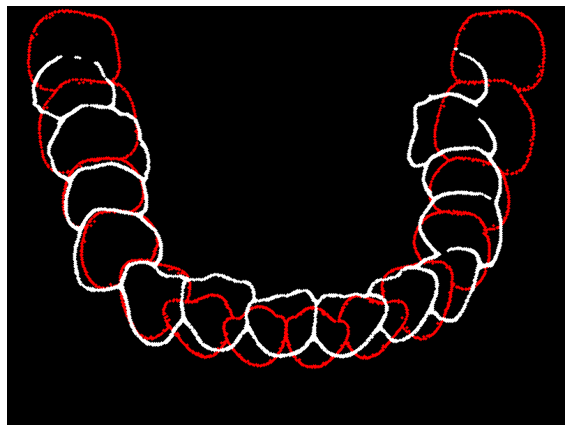

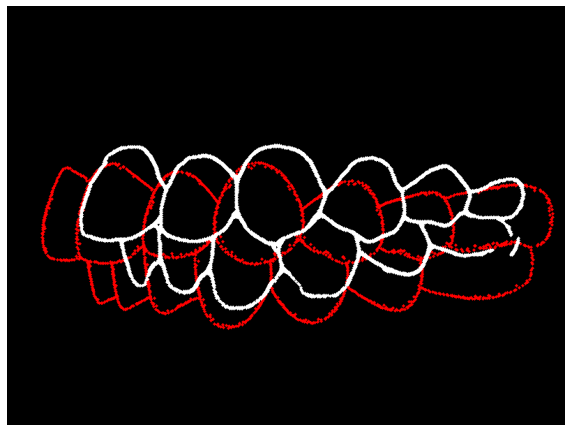

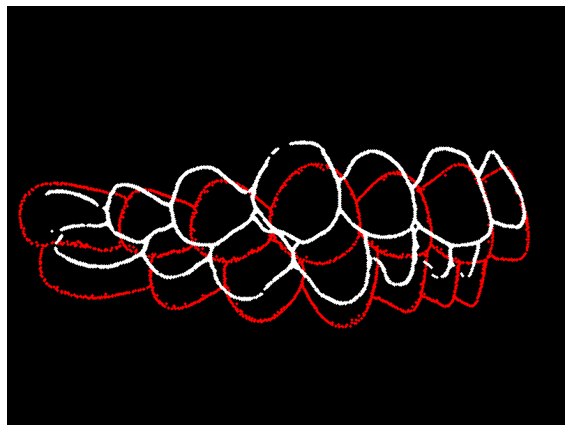

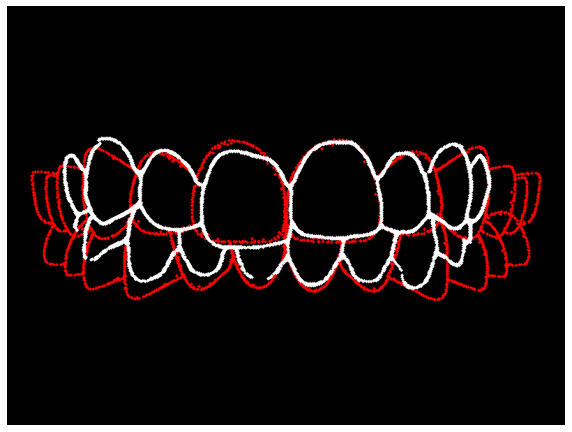

In [23]:
for phtype in photoTypes:
    _ = emopt.showEdgeMaskPredictionWithGroundTruth(phtype, canvasShape=None, dilate=True)

In [24]:
# phase 0: grid search parallelled by Ray

# stage0MatFile = os.path.join(STAGE0_MAT_DIR, "E-step-result-stage0-{}.mat".format(TagID))
print("-"*100)
print("Start Grid Search.")

# parallel function supported by Ray
emopt.searchDefaultRelativePoseParams()
emopt.gridSearchExtrinsicParams()
emopt.gridSearchRelativePoseParams()

print("ex_rxyz: ", emopt.ex_rxyz)
print("ex_txyz: ", emopt.ex_txyz)
print("rela_rxyz: ", emopt.rela_rxyz)
print("rela_txyz: ", emopt.rela_txyz)
print("focal length: ", emopt.focLth)
print("d_pixel: ", emopt.dpix)
print("u0: {}, v0: {}".format(emopt.u0, emopt.v0))


----------------------------------------------------------------------------------------------------
Start Grid Search.
rela.t.z 0
rela.t.z 3
rela.t.z 6
rela.t.z 0
Best param guess:  0
Estimate camera params of  PHOTO.FRONTAL
--------------------------------------------------
PHOTO.UPPER r.x [1.88495559 2.04203522 2.19911486 2.35619449 2.51327412]
Best param guess:  2.356194490192345
Estimate camera params of  PHOTO.UPPER
--------------------------------------------------
PHOTO.LOWER r.x [-1.88495559 -2.04203522 -2.19911486 -2.35619449 -2.51327412]
Best param guess:  -2.356194490192345
Estimate camera params of  PHOTO.LOWER
--------------------------------------------------
PHOTO.LEFT r.xyz [[ 3.11  0.   -0.49]
 [ 3.05  0.   -0.73]
 [ 2.99  0.   -0.97]
 [ 2.9   0.   -1.2 ]
 [ 2.8   0.   -1.43]]
Best param guess:  [ 3.05  0.   -0.73]
Estimate camera params of  PHOTO.LEFT
--------------------------------------------------
PHOTO.RIGHT r.xyz [[3.11 0.   0.49]
 [3.05 0.   0.73]
 [2.99 0.   

In [25]:
maxiter = 10
stageIter = [5,2,10]

print("-"*100)
print("Start Stage 0.")
# Continue from checkpoint
stage = 0

# __print_camera_params(emopt)
emopt.expectation_step_5Views(stage, verbose=True)
# emopt.save_expectation_step_result_with_XRef(stage0MatFile, X_Ref)

# emopt.load_expectation_step_result(stage0MatFile, stage)
# emopt.expectation_step_5Views(stage, verbose=True)
# print("Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(emopt.X_trans, X_Ref)))        

----------------------------------------------------------------------------------------------------
Start Stage 0.
PHOTO.UPPER - unique pred points: 685 - E-step loss: 65.16
PHOTO.LOWER - unique pred points: 853 - E-step loss: 23.35
PHOTO.LEFT - unique pred points: 582 - E-step loss: 37.84
PHOTO.RIGHT - unique pred points: 644 - E-step loss: 27.32
PHOTO.FRONTAL - unique pred points: 806 - E-step loss: 13.45


In [26]:
E_loss = []
for it in range(stageIter[0]):
    emopt.maximization_step_5Views(stage, step=-1, maxiter=maxiter, verbose=False)

    print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
    emopt.expectation_step_5Views(stage, verbose=True)
    e_loss = np.sum(emopt.weightViews * emopt.loss_expectation_step)
    print("Sum of expectation step loss: {:.4f}".format(e_loss))
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
    if len(E_loss)>=2 and e_loss>=np.mean(E_loss[-2:]):
        print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
        E_loss.append(e_loss)
        break
    else:
        E_loss.append(e_loss)

M-step loss: 3364.7446
PHOTO.UPPER - unique pred points: 851 - E-step loss: 36.06
PHOTO.LOWER - unique pred points: 868 - E-step loss: 19.75
PHOTO.LEFT - unique pred points: 705 - E-step loss: 18.45
PHOTO.RIGHT - unique pred points: 728 - E-step loss: 12.14
PHOTO.FRONTAL - unique pred points: 896 - E-step loss: 7.45
Sum of expectation step loss: 93.8443
iteration: 0, real Root Mean Squared Surface Distance(mm): 2.3826
M-step loss: 2310.4045
PHOTO.UPPER - unique pred points: 857 - E-step loss: 29.94
PHOTO.LOWER - unique pred points: 797 - E-step loss: 19.19
PHOTO.LEFT - unique pred points: 736 - E-step loss: 14.83
PHOTO.RIGHT - unique pred points: 754 - E-step loss: 10.01
PHOTO.FRONTAL - unique pred points: 875 - E-step loss: 7.18
Sum of expectation step loss: 81.1572
iteration: 1, real Root Mean Squared Surface Distance(mm): 2.3826
M-step loss: 2136.0057
PHOTO.UPPER - unique pred points: 877 - E-step loss: 26.76
PHOTO.LOWER - unique pred points: 852 - E-step loss: 19.14
PHOTO.LEFT - un

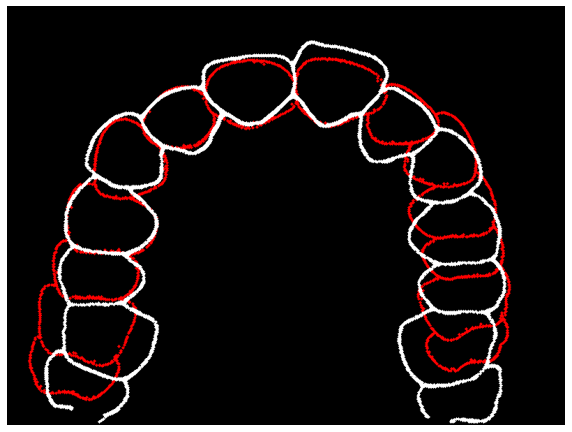

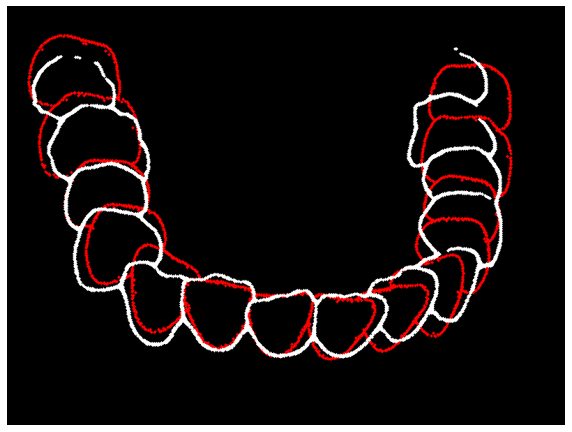

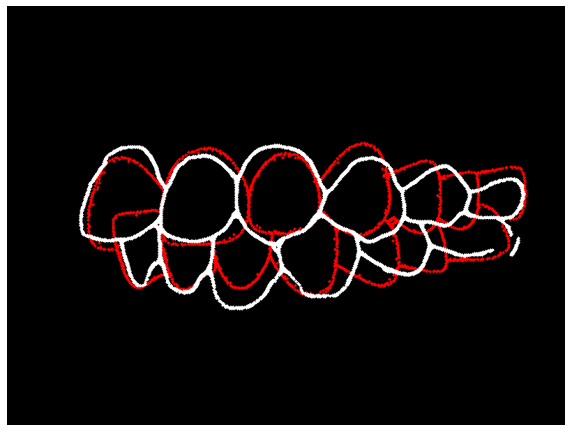

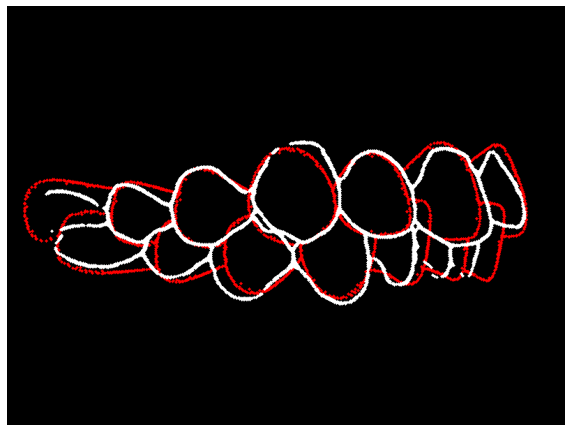

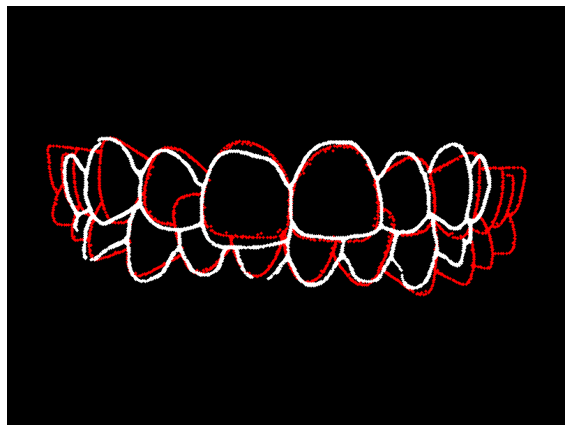

In [27]:
for phtype in photoTypes:
    _ = emopt.showEdgeMaskPredictionWithGroundTruth(phtype, canvasShape=None, dilate=True)

In [28]:
print("-"*100)
print("Start Stage 1.")

stage = 1
for it in range(stageIter[1]): 
    emopt.maximization_step_5Views(stage, step=-1, maxiter=maxiter, verbose=False)
    print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
    emopt.expectation_step_5Views(stage, verbose=True)
    e_loss = np.sum(emopt.weightViews * emopt.loss_expectation_step)
    print("Sum of expectation step loss: {:.4f}".format(e_loss))
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
    if e_loss >= E_loss[-1]: # len(E_loss)>=2 and e_loss>=np.mean(E_loss[-2:]):
        print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
        break
    else:
        E_loss.append(e_loss)


print("emopt.rowScaleXZ: ", emopt.rowScaleXZ)
print("approx tooth scale: ", np.prod(emopt.rowScaleXZ)**(1/3))


emopt.anistropicRowScale2ScalesAndTransVecs()      
print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))

----------------------------------------------------------------------------------------------------
Start Stage 1.
M-step loss: 1736.3378
PHOTO.UPPER - unique pred points: 977 - E-step loss: 15.95
PHOTO.LOWER - unique pred points: 822 - E-step loss: 17.08
PHOTO.LEFT - unique pred points: 711 - E-step loss: 13.12
PHOTO.RIGHT - unique pred points: 782 - E-step loss: 7.02
PHOTO.FRONTAL - unique pred points: 925 - E-step loss: 6.50
Sum of expectation step loss: 59.6770
iteration: 0, real Root Mean Squared Surface Distance(mm): 2.1687
M-step loss: 1564.1966
PHOTO.UPPER - unique pred points: 907 - E-step loss: 11.38
PHOTO.LOWER - unique pred points: 785 - E-step loss: 19.69
PHOTO.LEFT - unique pred points: 690 - E-step loss: 14.28
PHOTO.RIGHT - unique pred points: 773 - E-step loss: 7.62
PHOTO.FRONTAL - unique pred points: 936 - E-step loss: 7.66
Sum of expectation step loss: 60.6297
iteration: 1, real Root Mean Squared Surface Distance(mm): 2.0456
Early stop with last 3 e-step loss 68.4199

In [29]:
# Stage = 2 & 3
print("-"*100)
print("Start Stage 2 & 3.")
stage = 2


E_loss = []
for it in range(stageIter[2]):
    # emopt.maximization_step_5Views(stage=2, step=4, maxiter=maxiter, verbose=False)
    emopt.maximization_step_5Views(stage, step=2, maxiter=maxiter, verbose=False)
    emopt.maximization_step_5Views(stage, step=3, maxiter=maxiter, verbose=False)
    emopt.maximization_step_5Views(stage=3, step=-1, maxiter=maxiter, verbose=False)
    emopt.maximization_step_5Views(stage, step=1, maxiter=maxiter, verbose=False)
    print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
    emopt.expectation_step_5Views(stage=3, verbose=True)
    e_loss = np.sum(emopt.weightViews * emopt.loss_expectation_step)
    print("Sum of expectation step loss: {:.4f}".format(e_loss))
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
    if len(E_loss)>=2 and (e_loss>=np.mean(E_loss[-2:])):
        print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
        break
    else:
        E_loss.append(e_loss)


# __print_camera_params(emopt)
# __print_metrics(emopt)

----------------------------------------------------------------------------------------------------
Start Stage 2 & 3.
M-step loss: 1019.7241
PHOTO.UPPER - unique pred points: 1228 - E-step loss: 4.92
PHOTO.LOWER - unique pred points: 1083 - E-step loss: 6.17
PHOTO.LEFT - unique pred points: 733 - E-step loss: 8.64
PHOTO.RIGHT - unique pred points: 890 - E-step loss: 3.75
PHOTO.FRONTAL - unique pred points: 1081 - E-step loss: 4.08
Sum of expectation step loss: 27.5562
iteration: 0, real Root Mean Squared Surface Distance(mm): 1.9511
M-step loss: 633.1091
PHOTO.UPPER - unique pred points: 1334 - E-step loss: 2.81
PHOTO.LOWER - unique pred points: 1147 - E-step loss: 2.58
PHOTO.LEFT - unique pred points: 767 - E-step loss: 6.56
PHOTO.RIGHT - unique pred points: 963 - E-step loss: 3.05
PHOTO.FRONTAL - unique pred points: 1045 - E-step loss: 2.78
Sum of expectation step loss: 17.7765
iteration: 1, real Root Mean Squared Surface Distance(mm): 1.9138
M-step loss: 479.6081
PHOTO.UPPER - uni

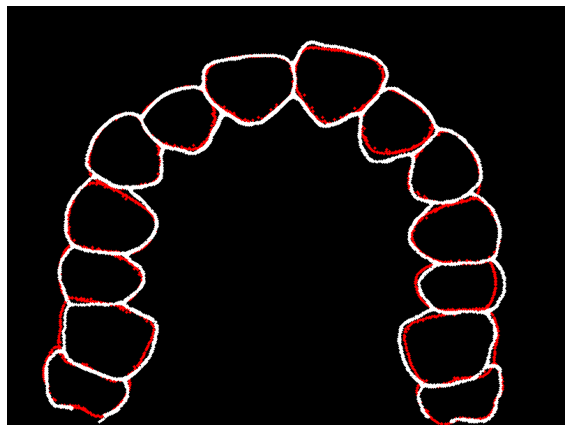

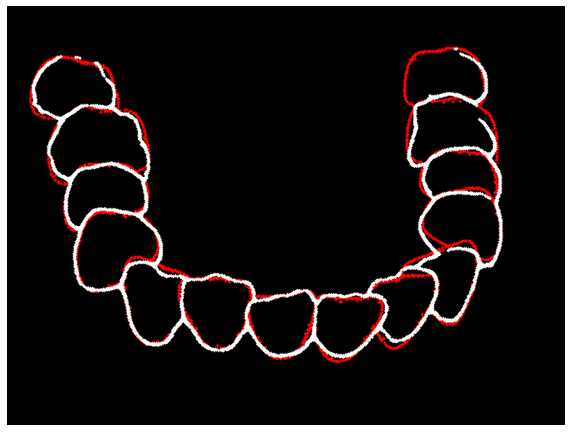

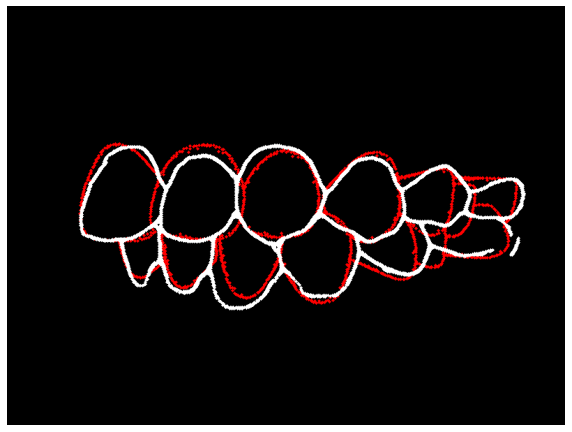

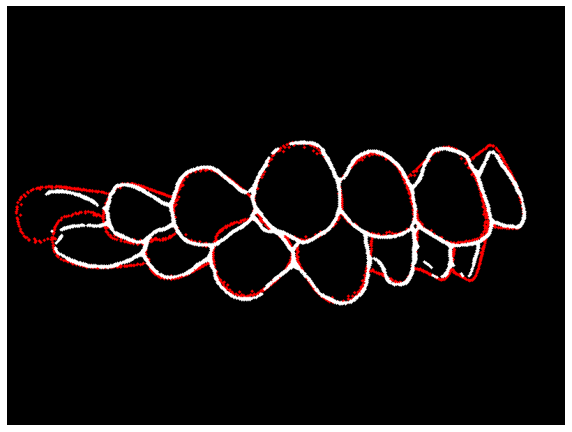

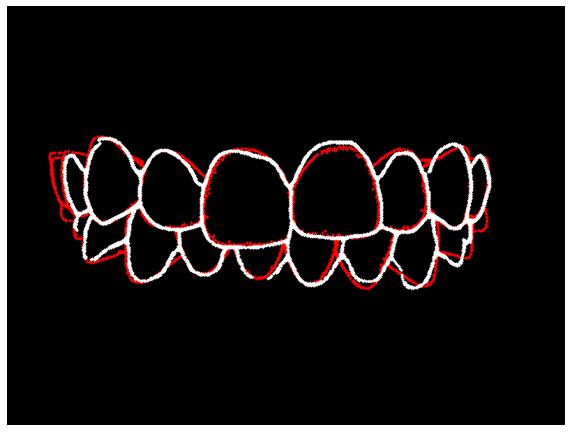

In [30]:
for phtype in photoTypes:
    _ = emopt.showEdgeMaskPredictionWithGroundTruth(phtype, canvasShape=None, dilate=True)

In [31]:
print("-"*100)
print("Evaluation.")

invRotVecXYZVars = invRotVecXYZVars.reshape(-1,3)
invTransVecXYZVars = invTransVecXYZVars.reshape(-1,3)
print("standard transVecXYZs:")
print((emopt.transVecXYZs - emopt.meanTransVecXYZs) / np.sqrt(invTransVecXYZVars[Mask]))
print("standard rotVecXYZs:")
print((emopt.rotVecXYZs - emopt.meanRotVecXYZs) / np.sqrt(invRotVecXYZVars[Mask]))
print("scales:")
print(emopt.scales)
print("feature vectors:")
print(emopt.featureVec)

# 不考虑第二磨牙
withoutSecondMolarMask = np.tile(np.array([1,1,1,1,1,1,0],dtype=np.bool_),(4,))
print("Without Second Molar, Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(emopt.X_trans[withoutSecondMolarMask[Mask]], X_Ref[withoutSecondMolarMask[Mask]])))

# # Save Demo Result

# demoH5File = os.path.join(DEMO_H5_DIR, "demo_TagID={}.h5".format(TagID))
# emopt.saveDemo2H5(demoH5File, TagID, X_Ref)

----------------------------------------------------------------------------------------------------
Evaluation.
standard transVecXYZs:
[[ 0.05360685 -0.52358709  0.68340483]
 [-0.10430558 -0.08998614  0.1570227 ]
 [-0.51781811  0.57952565  0.3077125 ]
 [-0.07815352  0.29796029 -0.18038322]
 [ 0.42278621  0.31805208 -0.59038945]
 [ 1.7500502  -0.41451934 -1.51474526]
 [ 1.10730245 -0.21299636 -0.96376536]
 [-0.07063126 -0.05767013  0.98963681]
 [-0.42177518  0.47368203  0.57088502]
 [ 0.29782524  0.24322994  0.34165242]
 [ 0.51757517  0.68536304  0.07818139]
 [-0.71647701  0.20779677  0.00826793]
 [-1.14920417  0.06098708 -1.02795024]
 [-0.69690559 -0.10644651 -0.76393716]
 [-0.08714201 -0.2806205   0.50327841]
 [ 0.34735388 -1.00045558  0.31047791]
 [ 0.58179143 -0.47549316  0.34183173]
 [ 0.81940122  0.99820934 -0.20269608]
 [-0.29651334  1.419523    0.16850661]
 [-0.45134017 -0.05263322 -0.56530026]
 [-0.80493141 -0.05891141 -0.59345636]
 [-0.07405857 -0.13853157  0.3158147 ]
 [-0.1

In [10]:
def showEdgeMaskPredictionWithGroundTruth(emopt, photoType, canvasShape=None, dilate=True):
    # red: prediction, white: ground truth
    ph = photoType.value
    if not bool(canvasShape):
        canvasShape = emopt.edgeMask[ph].shape
    canvas = np.zeros((*canvasShape,3), dtype=np.float64)
    h, w = emopt.edgeMask[ph].shape
    
    edgeTrue = np.zeros(canvasShape, dtype=np.float64)
    pix_true = emopt.P_true[ph].astype(np.int32)
    edgeTrue[pix_true[:,1], pix_true[:,0]] = 1. # white: ground truth
    if dilate == True:
        edgeTrue = skimage.morphology.binary_dilation(edgeTrue, skimage.morphology.disk(2)) # dilation edge prediction for visualization
    canvas[:,:,0] = edgeTrue
    canvas[:,:,1] = edgeTrue
    canvas[:,:,2] = edgeTrue

    edgePred = np.zeros(canvasShape, dtype=np.float64)
    pix_pred = emopt.P_pred[ph].astype(np.int32)
    edgePred[pix_pred[:,1], pix_pred[:,0]] = 1. # red: edge prediction
    if dilate == True:
        edgePred = skimage.morphology.binary_dilation(edgePred, skimage.morphology.disk(2)) # dilation edge prediction for visualization
    canvas[:,:,0] = np.max(np.stack([edgePred,canvas[:,:,0]]), axis=0)

    plt.figure(figsize = (10,10))
    plt.axis('off')
    plt.imshow(canvas)
    return canvas

def showEdgePrediction(emopt, photoType, canvasShape=None, dilate=True):
    # red: prediction, white: ground truth
    ph = photoType.value
    if not bool(canvasShape):
        canvasShape = emopt.edgeMask[ph].shape
    canvas = np.zeros((*canvasShape,3), dtype=np.float64)
    h, w = emopt.edgeMask[ph].shape
    # canvas[:h,:w,:] = emopt.edgeMask[ph][:,:,None] # white: ground truth

    edgePred = np.zeros(canvasShape, dtype=np.float64)
    pix_pred = emopt.P_pred[ph].astype(np.int32)
    edgePred[pix_pred[:,1], pix_pred[:,0]] = 1. # red: edge prediction
    if dilate == True:
        edgePred = skimage.morphology.binary_dilation(edgePred, skimage.morphology.disk(3)) # dilation edge prediction for visualization
    canvas[:,:,0] = edgePred

    plt.figure(figsize = (10,10))
    plt.axis('off')
    plt.imshow(canvas)
    return canvas

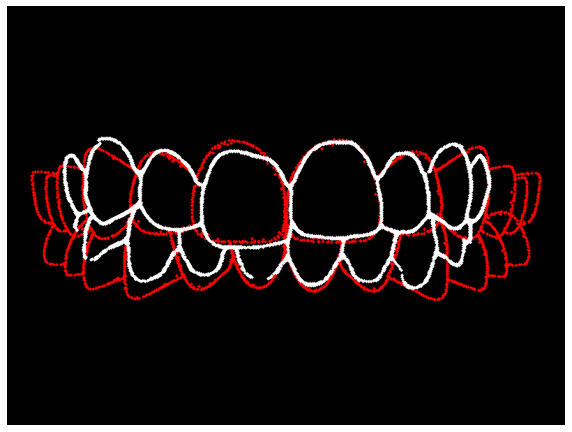

In [13]:
_ = showEdgeMaskPredictionWithGroundTruth(emopt, PHOTO.FRONTAL, canvasShape=None, dilate=True)

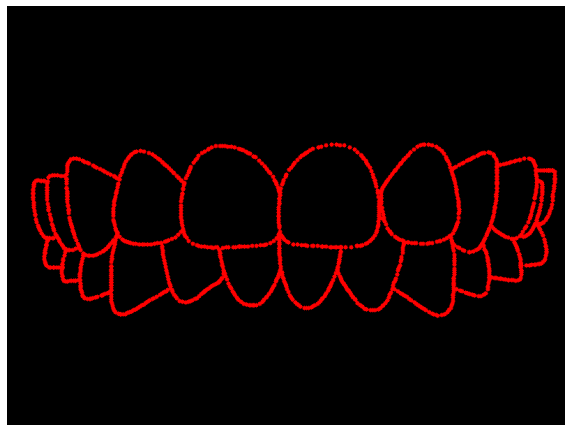

In [40]:
_ = showEdgePrediction(emopt, PHOTO.FRONTAL, canvasShape=None, dilate=True)